<a href="https://colab.research.google.com/github/Himank-J/ERAV2/blob/main/S8/ERAV2_S8_BN_Himank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
    ]
)


In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 3, 32, 32])
labels.shape: torch.Size([128])


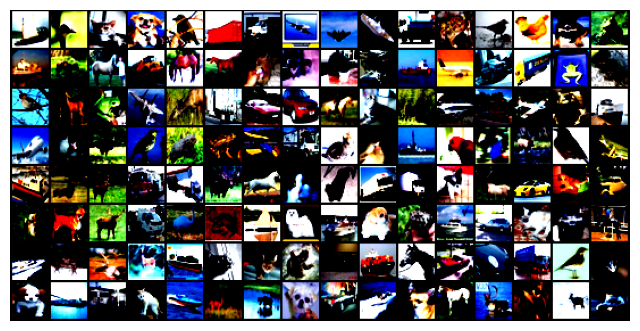

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, labels in train_loader:
  print('images.shape:', images.shape)
  print('labels.shape:', labels.shape)

  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0).clamp(0,1))
  break

In [11]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
       # C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool1(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [12]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             128
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           2,304
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []
misclassified_pred_labels = []
misclassified_true_labels = []

def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            try:
              misclassified_indices = ~pred.eq(target.view_as(pred)).squeeze()
              misclassified_pred_labels.extend(pred[misclassified_indices].squeeze().tolist())
              misclassified_true_labels.extend(target[misclassified_indices].tolist())
              misclassified_images.extend(data[misclassified_indices])
            except Exception as e:
              pass

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [20]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.2192014455795288 Batch_id=390 Accuracy=41.56: 100%|██████████| 391/391 [00:19<00:00, 20.21it/s]



Test set: Average loss: 1.4424, Accuracy: 4750/10000 (47.50%)

EPOCH: 1


Loss=1.1040232181549072 Batch_id=390 Accuracy=57.19: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]



Test set: Average loss: 1.1823, Accuracy: 5779/10000 (57.79%)

EPOCH: 2


Loss=1.040682077407837 Batch_id=390 Accuracy=62.07: 100%|██████████| 391/391 [00:16<00:00, 23.78it/s]



Test set: Average loss: 1.1224, Accuracy: 6039/10000 (60.39%)

EPOCH: 3


Loss=0.768303394317627 Batch_id=390 Accuracy=64.99: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]



Test set: Average loss: 1.0374, Accuracy: 6255/10000 (62.55%)

EPOCH: 4


Loss=0.8093557357788086 Batch_id=390 Accuracy=67.26: 100%|██████████| 391/391 [00:17<00:00, 22.92it/s]



Test set: Average loss: 0.9661, Accuracy: 6494/10000 (64.94%)

EPOCH: 5


Loss=1.0154834985733032 Batch_id=390 Accuracy=69.22: 100%|██████████| 391/391 [00:17<00:00, 22.70it/s]



Test set: Average loss: 0.9242, Accuracy: 6670/10000 (66.70%)

EPOCH: 6


Loss=0.674687385559082 Batch_id=390 Accuracy=72.42: 100%|██████████| 391/391 [00:16<00:00, 23.67it/s]



Test set: Average loss: 0.8184, Accuracy: 7071/10000 (70.71%)

EPOCH: 7


Loss=0.8642457723617554 Batch_id=390 Accuracy=72.64: 100%|██████████| 391/391 [00:16<00:00, 23.52it/s]



Test set: Average loss: 0.8165, Accuracy: 7076/10000 (70.76%)

EPOCH: 8


Loss=0.7503461241722107 Batch_id=390 Accuracy=73.35: 100%|██████████| 391/391 [00:17<00:00, 21.72it/s]



Test set: Average loss: 0.7994, Accuracy: 7145/10000 (71.45%)

EPOCH: 9


Loss=1.038688063621521 Batch_id=390 Accuracy=73.22: 100%|██████████| 391/391 [00:16<00:00, 23.38it/s]



Test set: Average loss: 0.7942, Accuracy: 7178/10000 (71.78%)

EPOCH: 10


Loss=0.7902464270591736 Batch_id=390 Accuracy=73.53: 100%|██████████| 391/391 [00:17<00:00, 22.12it/s]



Test set: Average loss: 0.7958, Accuracy: 7177/10000 (71.77%)

EPOCH: 11


Loss=0.8156968951225281 Batch_id=390 Accuracy=73.59: 100%|██████████| 391/391 [00:16<00:00, 23.31it/s]



Test set: Average loss: 0.8037, Accuracy: 7135/10000 (71.35%)

EPOCH: 12


Loss=0.7307831048965454 Batch_id=390 Accuracy=73.78: 100%|██████████| 391/391 [00:17<00:00, 22.29it/s]



Test set: Average loss: 0.7952, Accuracy: 7175/10000 (71.75%)

EPOCH: 13


Loss=0.7963790893554688 Batch_id=390 Accuracy=74.14: 100%|██████████| 391/391 [00:16<00:00, 23.78it/s]



Test set: Average loss: 0.7937, Accuracy: 7176/10000 (71.76%)

EPOCH: 14


Loss=0.5950206518173218 Batch_id=390 Accuracy=74.17: 100%|██████████| 391/391 [00:17<00:00, 22.13it/s]



Test set: Average loss: 0.7879, Accuracy: 7203/10000 (72.03%)

EPOCH: 15


Loss=0.8946817517280579 Batch_id=390 Accuracy=74.08: 100%|██████████| 391/391 [00:16<00:00, 23.69it/s]



Test set: Average loss: 0.7918, Accuracy: 7174/10000 (71.74%)

EPOCH: 16


Loss=0.7928290367126465 Batch_id=390 Accuracy=74.23: 100%|██████████| 391/391 [00:17<00:00, 22.47it/s]



Test set: Average loss: 0.7883, Accuracy: 7189/10000 (71.89%)

EPOCH: 17


Loss=0.5362123847007751 Batch_id=390 Accuracy=74.25: 100%|██████████| 391/391 [00:16<00:00, 23.58it/s]



Test set: Average loss: 0.7901, Accuracy: 7185/10000 (71.85%)

EPOCH: 18


Loss=0.635492742061615 Batch_id=390 Accuracy=74.30: 100%|██████████| 391/391 [00:17<00:00, 22.95it/s]



Test set: Average loss: 0.7862, Accuracy: 7208/10000 (72.08%)

EPOCH: 19


Loss=0.7206882834434509 Batch_id=390 Accuracy=74.21: 100%|██████████| 391/391 [00:16<00:00, 23.46it/s]



Test set: Average loss: 0.7853, Accuracy: 7224/10000 (72.24%)



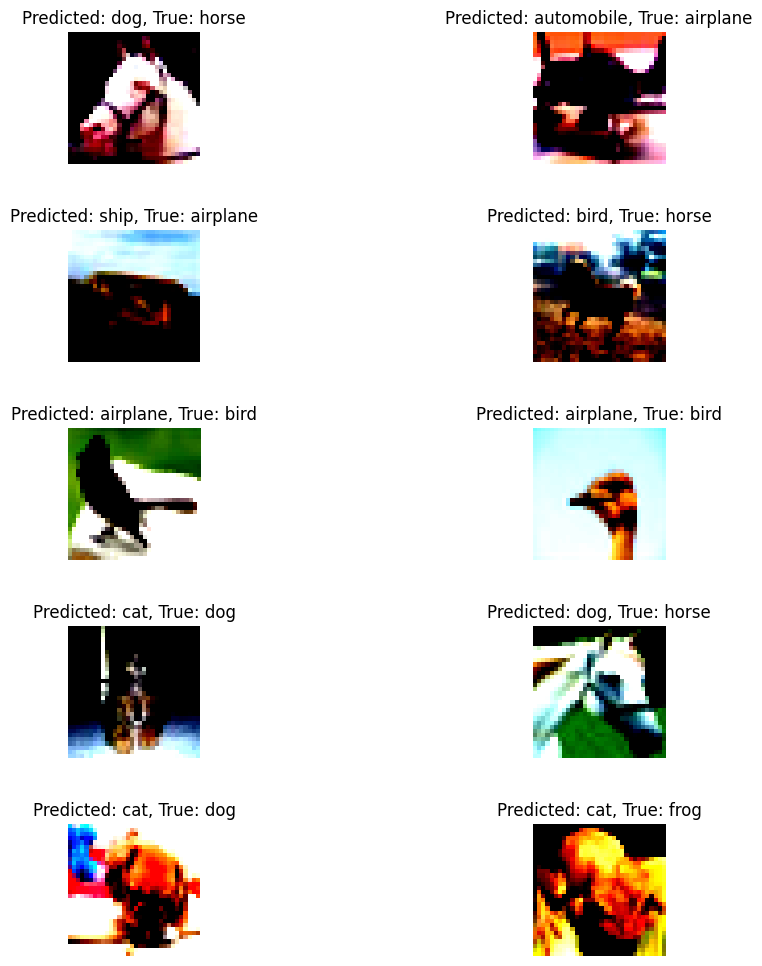

In [21]:

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def visualize_misclassified_images(images, pred_labels, true_labels):
    fig, axs = plt.subplots(5, 2, figsize=(10, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    axs = axs.ravel()

    for i in range(len(images)):
        pred_class_name = class_names[pred_labels[i]]
        true_class_name = class_names[true_labels[i]]

        axs[i].imshow(images[i].permute(1, 2, 0).cpu().clamp(0,1))
        axs[i].set_title(f'Predicted: {pred_class_name}, True: {true_class_name}')
        axs[i].axis('off')

    plt.show()

visualize_misclassified_images(misclassified_images[:10], misclassified_pred_labels[:10], misclassified_true_labels[:10])


In [22]:
train_losses_tensor = torch.tensor(train_losses).cuda()
train_losses_tensor = train_losses_tensor.cpu().numpy()

train_acc_tensor = torch.tensor(train_acc).cuda()
train_acc_tensor = train_acc_tensor.cpu().numpy()

test_losses_tensor = torch.tensor(test_losses).cuda()
test_losses_tensor = test_losses_tensor.cpu().numpy()

test_acc_tensor = torch.tensor(test_acc).cuda()
test_acc_tensor = test_acc_tensor.cpu().numpy()

Text(0.5, 1.0, 'Test Accuracy')

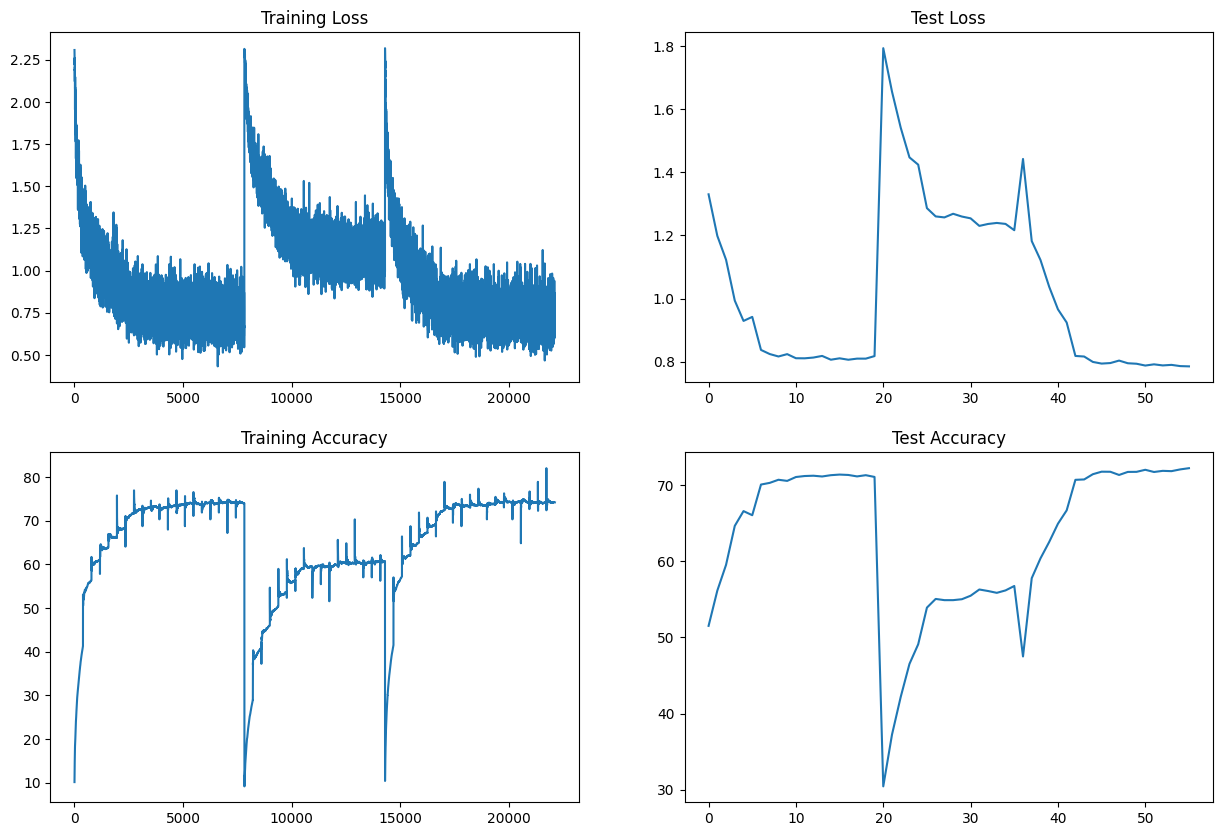

In [23]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_tensor)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_tensor)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_tensor)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_tensor)
axs[1, 1].set_title("Test Accuracy")